In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats import multitest

Fold enrichment MT vs WT promoters

In [2]:
od = pd.read_excel('/Users/bamudamaris/ownCloud2/labs/datasets/gfp_measurement/clones_batch3_R2_21.06.24.xlsx', sheet_name = 'OD600', index_col = 0)
gfp = pd.read_excel('/Users/bamudamaris/ownCloud2/labs/datasets/gfp_measurement/clones_batch3_R2_21.06.24.xlsx', sheet_name = 'gfp', index_col = 0)

In [3]:
#average out od of replicates

od.columns = [col.split('_')[0] for col in od.columns]
o = od.groupby(od.columns, axis=1)
od_averaged = o.mean()

#average out fluorescence of replicates
gfp.columns = [col.split('_')[0] for col in gfp.columns]
f = gfp.groupby(gfp.columns, axis=1)
gfp_averaged = f.mean()

# Normalize OD600 by the blank 
normalized_od_blank = od_averaged.sub(od_averaged['Blank'], axis=0)

# Normalize fluorescence by the blank and OD600
normalized_flo_blank = gfp_averaged.sub(gfp_averaged['Blank'], axis=0)
fluorescence_od = normalized_flo_blank / normalized_od_blank

targets = fluorescence_od.drop(['Blank', 'pOT2'], axis=1)
grouped_columns = {}
group_pairs = []
for column in targets.columns:
    prefix = column.split('-')[0]
    if prefix not in grouped_columns:
        grouped_columns[prefix] = []
    grouped_columns[prefix].append(column)

for prefix, columns in grouped_columns.items():
    if len(columns) == 2:
        group_pairs.append((columns[0], columns[1]))

/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/numpy/core/_methods.py:212: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


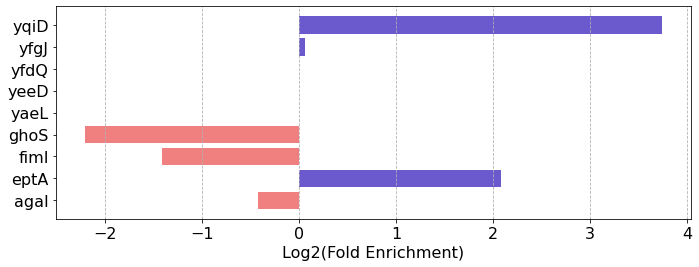

In [4]:
# Compute fold enrichment for each test sample compared to its control
enrichment_results = {}
for group1, group2 in group_pairs:
    group1_values = fluorescence_od[group1].dropna()
    group2_values = fluorescence_od[group2].dropna()
    
    # Compute fold enrichment (mean of test values / mean of control values)
    fold_enrichment = group2_values.mean() / group1_values.mean()
    
    # Perform paired samples t-test
    t_stat, p_value = stats.ttest_rel(group1_values, group2_values)
    
    # Check if the enrichment is significant (p-value < 0.05)
    significant_enrichment = p_value < 0.05
    
    # Store fold enrichment and significance information
    enrichment_results[group2] = {'fold_enrichment': fold_enrichment, 'p_value': p_value, 'significant_enrichment': significant_enrichment}

# Extract gene names, fold enrichment values, and significance information
genes = list(enrichment_results.keys())
fold_enrichments = [result['fold_enrichment'] for result in enrichment_results.values()]
p_values = [result['p_value'] for result in enrichment_results.values()]
significant_enrichments = [result['significant_enrichment'] for result in enrichment_results.values()]

# Perform multiple testing correction for p-values (e.g., Benjamini-Hochberg procedure)
reject, p_adjusted, _, _ = multitest.multipletests(p_values, method='fdr_bh')

# Create a DataFrame to summarize the results
results_df = pd.DataFrame({
    'Gene': genes,
    'Fold_Enrichment': fold_enrichments,
    'P_Value': p_values,
    'Adjusted_P_Value': p_adjusted,
    'Significant_Enrichment': significant_enrichments
})

# Take log2 transformation of fold enrichment values
results_df['Log2_Fold_Enrichment'] = np.log2(results_df['Fold_Enrichment'])

# Define colors based on fold enrichment values
bar_colors = ['slateblue' if fe > 0 else 'lightcoral' for fe in results_df['Log2_Fold_Enrichment']]

# Create horizontal bar plot
plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 16})
bar_positions = np.arange(len(results_df))

plt.barh(bar_positions, results_df['Log2_Fold_Enrichment'], color=bar_colors)
plt.yticks(bar_positions, results_df['Gene'].apply(lambda x: x.split('-')[0]))
plt.xlabel('Log2(Fold Enrichment)')
plt.grid(axis='x', linestyle='--')

plt.tight_layout()
#plt.savefig('/Users/bamudamaris/ownCloud2/labs/figures/gfp_analysis/C3_R2/fold_enrichment.svg', dpi = 300)

In [5]:
results_df

,Gene,Fold_Enrichment,P_Value,Adjusted_P_Value,Significant_Enrichment,Log2_Fold_Enrichment
0,agaI-test,0.745841,3.805350e-03,NaN,True,-0.423060
1,eptA-test,4.228468,3.762538e-05,NaN,True,2.080135
2,fimI-test,0.377789,7.142065e-04,NaN,True,-1.404347
3,ghoS-test,0.216817,9.252342e-04,NaN,True,-2.205451
4,yaeL-test,NaN,NaN,NaN,False,NaN
5,yeeD-test,0.000000,NaN,NaN,False,-inf
6,yfdQ-test,NaN,NaN,NaN,False,NaN
7,yfgJ-test,1.045060,8.095853e-01,NaN,False,0.063586
8,yqiD-test,13.358693,8.090455e-20,NaN,True,3.739707
